# CS445: Term Project

#### Victor Weeks & Josh Lutz

Note: I think I am going to explore changing my idea to taking current inventory info and deciding how best to make a profit

#### Get material data

In [47]:
import urllib.request, urllib.error, urllib.parse
api_key = "Bearer 51DD34C0-ABC4-E54C-A3F2-8E7500AE5F74705C18C6-B5BD-431A-8A6A-304EB4F2A24A"
headers = {'Authorization': api_key}

In [48]:
def getAccountMaterials():
        """Makes a request on the GW2 API."""
        url = 'https://api.guildwars2.com/v2/account/materials/'
        r = urllib.request.Request(url, headers=headers)
        if 'Cookie' not in headers:
            resp = urllib.request.urlopen(r)
            if 'set-cookie' in resp.headers:
                headers['Cookie'] = resp.headers['set-cookie'].split(';', 1)[0]
            return json.loads(resp.read())
        return json.loads(urllib.request.urlopen(r).read())

In [62]:
materials = getAccountMaterials()

In [70]:
materials[0]

{'category': 5, 'count': 56, 'id': 12134}

In [73]:
def saveMaterials(materials):
    playerMats = {}
    for mat in materials:        
        if mat['id'] in itemIDs:
            playerMats[mat['id']] = mat['count']
    with open('playerMaterials.txt', 'w') as outFile:
        json.dump(playerMats, outFile)

In [74]:
saveMaterials(materials)

In [76]:
matData = open('playerMaterials.txt')
matData = json.load(matData)
matData['19725']

151

## Introduction

In [479]:
from gw2spidy import Gw2Spidy as spidy # allows retrieval of market information
import numpy as np
import json
import random
import neuralnetworksA4 as nn
import matplotlib.pyplot as plt
%matplotlib inline

### Data

In [480]:
itemIDs = (19718,19720,19697,19680,19719,19738,19723,19710,
           19739,19740,19699,19683,19703,19687,19728,19733,19726,19713,
           19741,19742,19698,19682,19730,19734,19727,19714,
           19743,19744,19702,19686,19731,19736,19736,19724,19711,
           19748,19747,19700,19684,19729,19735,19722,19709,
           19745,19746,19701,19685,19732,19737,19725,19712)

In [481]:
from datetime import datetime

In [41]:
# This function adds current timepoint data to previous data and saves it
def saveItemTimepoint(itemIDs):
    now = datetime.now()
    allItems = np.load('itemData.npy')
    for id in itemIDs:
        item = spidy.getItemData(id)
        itemData = [item['data_id'], item['max_offer_unit_price'], item['min_sale_unit_price'], item['offer_availability'], item['sale_availability'], item['sale_price_change_last_hour'], item['offer_price_change_last_hour'],
                   now.year, now.month, now.day, now.hour, now.minute, now.second]
        allItems = np.vstack((allItems, itemData))
    np.save('itemData', allItems)
    print('Saved item data at : %s' % datetime.now())

In [42]:
saveItemTimepoint(itemIDs)

Saved item data at : 2018-05-05 17:59:01.579238


In [538]:
itemTimeData = np.load('itemData.npy')
itemTimeData.shape

(9792, 13)

In [483]:
names = ['item_id', 'max_offer_price', 'min_sale_price', 'offer_availability', 'sale_availability', 'sale_price_change', 'offer_price_change', 'year', 'month', 'day', 'hour', 'minute', 'second']

In [880]:
def makeItemData(itemID=19718, allItems=False, splitData=False, stepsAheadToPredict=4):
    itemTimeData = np.load('itemData.npy')
    if allItems:
        itemData = np.mean(itemTimeData[0:50], axis=0).reshape((1,-1))
        for bucket in itemTimeData[51::51]:
            itemData = np.vstack((itemData, np.mean(bucket.reshape((1,-1)), axis=0).reshape((1,-1))))
    else:
        itemData = itemTimeData[np.where(itemTimeData[:]==itemID)[0]]
    X = itemData[:-stepsAheadToPredict, 1:7].copy()
    T = itemData[stepsAheadToPredict:, 1:2].copy()
    if splitData:
        rows = np.arange(X.shape[0])
        nTrain = int(X.shape[0] * 0.7)
        Xtrain = X[rows[:nTrain],:]
        Ttrain = T[rows[:nTrain],:]
        Xtest = X[rows[nTrain:],:]
        Ttest = T[rows[nTrain:],:]
        return Xtrain, Ttrain, Xtest, Ttest
    else:        
        return X, T, itemData

Note: Had to make sure to copy the X and T data because of how the Time-Embedded data is accessed.

In [955]:
Xtrain, Ttrain, items = makeItemData(allItems=True) # training with all items
Xtest, Ttest, item1 = makeItemData(19735)
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((197, 6), (197, 1), (197, 6), (197, 1))

In [905]:
Xtrain, Ttrain, Xtest, Ttest = makeItemData(19743, allItems=True, splitData=True) #Train and test with all items
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((137, 6), (137, 1), (59, 6), (59, 1))

#### Time-Embedding

In [899]:
def rollingWindows(X, windowSize):    
    nSamples, nAttributes = X.shape
    nWindows = nSamples - windowSize + 1
    # Shape of resulting matrix
    newShape = (nWindows, nAttributes * windowSize)
    itemSize = X.itemsize  # number of bytes
    # Number of bytes to increment to starting element in each dimension
    strides = (nAttributes * itemSize, itemSize)
    return np.lib.stride_tricks.as_strided(X, shape=newShape, strides=strides)

In [956]:
XtrainW = rollingWindows(Xtrain, 2)
TtrainW = rollingWindows(Ttrain, 2)
XtestW = rollingWindows(Xtest, 2)
TtestW = rollingWindows(Ttest, 2)
XtrainW.shape, TtrainW.shape, XtestW.shape, TtestW.shape

((196, 12), (196, 2), (196, 12), (196, 2))

In [957]:
Xtrain[0:2]

array([[  3.18580000e+02,   3.58220000e+02,   5.57863420e+05,
          1.63556236e+06,   0.00000000e+00,   0.00000000e+00],
       [  7.70000000e+01,   9.20000000e+01,   6.64614000e+05,
          4.51649000e+05,   0.00000000e+00,   0.00000000e+00]])

In [958]:
XtrainW[0]

array([  3.18580000e+02,   3.58220000e+02,   5.57863420e+05,
         1.63556236e+06,   0.00000000e+00,   0.00000000e+00,
         7.70000000e+01,   9.20000000e+01,   6.64614000e+05,
         4.51649000e+05,   0.00000000e+00,   0.00000000e+00])

In [959]:
nnet = nn.NeuralNetwork(Xtrain.shape[1], [10,10,10], Ttrain.shape[1])
nnet.train(Xtrain, Ttrain, 1000, verbose=True)

SCG: Iteration 100 fValue Eval 0.258425263853 Scale 0.000549755813888
SCG: Iteration 200 fValue Eval 0.209481074514 Scale 1e-15
SCG: Iteration 300 fValue Eval 0.168956496713 Scale 1e-15
SCG: Iteration 400 fValue Eval 0.15949002153 Scale 1e-15
SCG: Iteration 500 fValue Eval 0.14668772719 Scale 1e-15
SCG: Iteration 600 fValue Eval 0.137775777809 Scale 1e-15
SCG: Iteration 700 fValue Eval 0.133979337552 Scale 1e-15
SCG: Iteration 800 fValue Eval 0.131654566237 Scale 1e-15
SCG: Iteration 900 fValue Eval 0.130301201807 Scale 1e-15
SCG: Iteration 1000 fValue Eval 0.129268898888 Scale 1e-15


NeuralNetwork(6, [10, 10, 10], 1)
   Network was trained for 1001 iterations that took 2.7201 seconds. Final error is 0.3595398432558066.

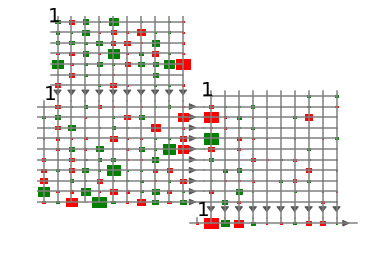

In [960]:
nnet.draw()

NeuralNetwork(6, [10, 10, 10], 1)
   Network was trained for 1001 iterations that took 2.7201 seconds. Final error is 0.3595398432558066.


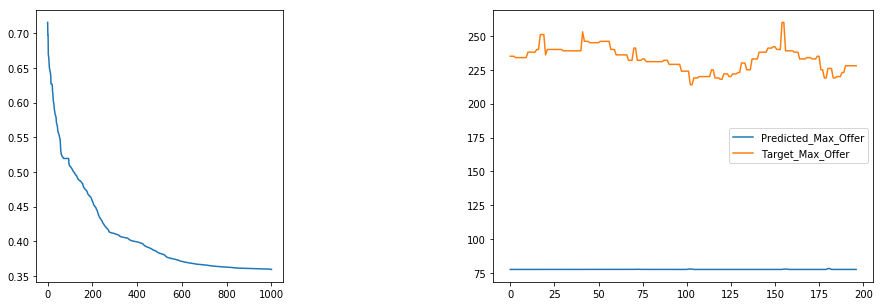

In [961]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(nnet.getErrors())
print(nnet)

Y = nnet.use(Xtest)
plt.subplot(1,2,2)
plt.plot(Y, label='Predicted_Max_Offer')
plt.plot(Ttest, label='Target_Max_Offer')
plt.legend();

In [962]:
keepTrain = [ len(np.unique(Trow))==1 for Trow in TtrainW ]
keepTest = [ len(np.unique(Trow))==1 for Trow in TtestW ]
sum(keepTrain)

166

In [963]:
XtrainW = XtrainW[keepTrain, :]
TtrainW = TtrainW[keepTrain, :]
TtrainW = TtrainW[:, 0:1] # reduce to single class label

XtestW = XtestW[keepTest, :]
TtestW = TtestW[keepTest, :]
TtestW = TtestW[:, 0:1] # reduce to single class label

In [964]:
nnet = nn.NeuralNetwork(XtrainW.shape[1], [10,10,10], TtrainW.shape[1])
nnet.train(XtrainW/(XtrainW.max(axis=0)), TtrainW/(TtrainW.max(axis=0)), 1000, verbose=True)

SCG: Iteration 100 fValue Eval 0.090104045071 Scale 1e-15
SCG: Iteration 200 fValue Eval 0.0379357269019 Scale 1e-15
SCG: Iteration 300 fValue Eval 0.0225561004734 Scale 1e-15
SCG: Iteration 400 fValue Eval 0.0148289516296 Scale 1e-15
SCG: Iteration 500 fValue Eval 0.0113948399782 Scale 1e-15
SCG: Iteration 600 fValue Eval 0.00879953727688 Scale 1e-15
SCG: Iteration 700 fValue Eval 0.00707082806544 Scale 1e-15
SCG: Iteration 800 fValue Eval 0.00610688640433 Scale 1e-15
SCG: Iteration 900 fValue Eval 0.00478952472594 Scale 1e-15
SCG: Iteration 1000 fValue Eval 0.00378912943805 Scale 1e-15


NeuralNetwork(12, [10, 10, 10], 1)
   Network was trained for 1001 iterations that took 2.7249 seconds. Final error is 0.06155590498113965.

NeuralNetwork(12, [10, 10, 10], 1)
   Network was trained for 1001 iterations that took 2.7249 seconds. Final error is 0.06155590498113965.


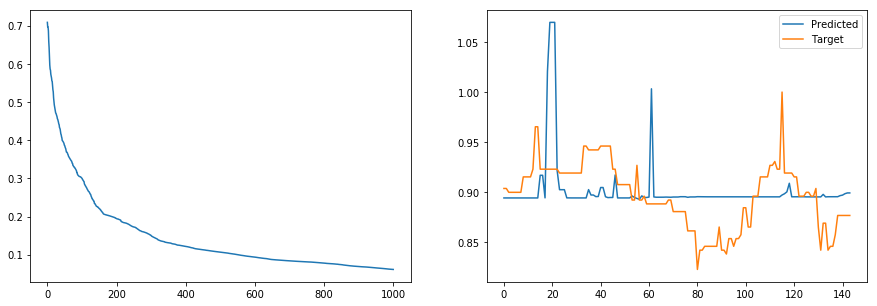

In [965]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(nnet.getErrors())
print(nnet)

Y = nnet.use(XtestW/(XtestW.max(axis=0)))
plt.subplot(1,2,2)
plt.plot(Y, label='Predicted')
plt.plot(TtestW/(TtestW.max(axis=0)), label='Target')
plt.legend();

hiddens = [0, [1], [1, 1], [1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1, 1], [5], [5, 5], [5, 5, 5], [5, 5, 5, 5], [5, 5, 5, 5, 5], [10], [10, 10], [10, 10, 10], [10, 10, 10, 10], [10, 10, 10, 10, 10], [20], [20, 20], [20, 20, 20], [20, 20, 20, 20], [20, 20, 20, 20, 20], [50], [50, 50], [50, 50, 50], [50, 50, 50, 50], [50, 50, 50, 50, 50]]
1.6040875717e-16
                       0         1           2
0                      0  1.107171  221.443841
1                    [1]  1.077876  157.385391
2                 [1, 1]  1.076172  157.382035
3              [1, 1, 1]  1.075109  157.388759
4           [1, 1, 1, 1]  1.074625  157.392186
5        [1, 1, 1, 1, 1]  1.074802  157.403119
6                    [5]  0.581100  169.430947
7                 [5, 5]  0.371077  155.849256
8              [5, 5, 5]  0.309750  155.355470
9           [5, 5, 5, 5]  0.318064  157.404214
10       [5, 5, 5, 5, 5]  0.429583  156.139960
11                  [10]  0.232727  152.781823
12              [10, 10]  0.144414  16

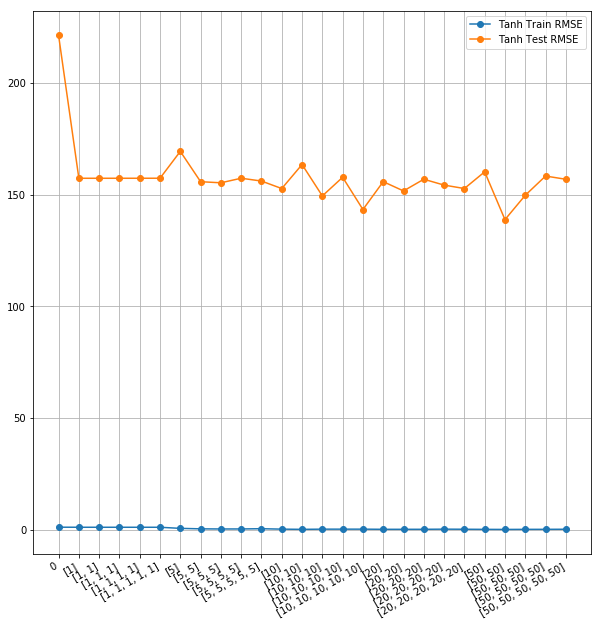

In [922]:
import pandas as pd
errors = []
hiddens = [0] + [[nu] * nl for nu in [1, 5, 10, 20, 50] for nl in [1, 2, 3, 4, 5]]
print('hiddens =', hiddens)
for hids in hiddens:
    nnet = nn.NeuralNetwork(XtrainW.shape[1], hids, TtrainW.shape[1])
    nnet.train(XtrainW, TtrainW, 1000)
    errors.append([hids, rmse(TtrainW, nnet.use(XtrainW)), rmse(TtestW, nnet.use(XtestW))])
errors = pd.DataFrame(errors)
print(errors)

plt.figure(figsize=(10, 10))
plt.plot(errors.values[:, 1:], 'o-')
plt.legend(('Tanh Train RMSE', 'Tanh Test RMSE'))
plt.xticks(range(errors.shape[0]), hiddens, rotation=30, horizontalalignment='right')
plt.grid(True)


#### Recurrent Neural Network

In [450]:
X[0:2]

array([[    77,     92, 664614, 451649,      0,      0],
       [    77,     92, 664614, 451649,      0,      0]])

In [ ]:
plt.figure(figsize=(15,15))
nrow, ncol = item1.shape
for c in range(ncol):
    plt.subplot(4, 4, c+1)
    plt.plot(item1[:, c])
    plt.tight_layout()

In [412]:
Tnames = names[1:2]
Xnames = names[1:]

In [328]:
def plotItemData(Tplot=0):
    plt.figure(figsize=(10,10))
    for c in range(X.shape[1]):           
        plt.subplot(3, 2, c+1)
        plt.plot(X[:, c], T[:, Tplot], 'o', alpha=0.5)
        plt.ylabel(Tnames[Tplot])
        plt.xlabel(Xnames[c])
        plt.tight_layout()

In [ ]:
plotItemData(Tplot=0)

In [ ]:
plotItemData(Tplot=1)

In [ ]:
plotItemData(Tplot=2)

In [ ]:
plotItemData(Tplot=3)

In [ ]:
plotItemData(Tplot=4)

In [ ]:
plotItemData(Tplot=5)

In [362]:
def train(X, T, nUnits=3, nIterations=2000, learningRate=0.01, W=None):
    
    nSamples, nInputs = X.shape
    nTargets = T.shape[1]

    if W is None:
        W = np.random.uniform(-1, 1, (1+nInputs+nUnits, nUnits)) / np.sqrt(1+nInputs+nUnits)

    Y = np.zeros((nSamples, nUnits))
    P = np.zeros((1+nInputs+nUnits, nUnits, nUnits))
    Z = np.zeros((1+nInputs+nUnits, 1))
    Z[0,:] = 1
    delta = np.zeros((nUnits, 1))
    dW = np.zeros_like(W)

    errors = np.zeros(nIterations)
    errors[:] = np.nan
    Ws = np.zeros((nIterations, (1+nInputs+nUnits)*nUnits))
    Ws[:] = np.nan

    fig = plt.figure(figsize=(10, 15))

    for iteration in range(nIterations):
        Y[:] = 0
        P[:] = 0
        dW[:] = 0
        errSum = 0
        Z[1+nInputs:] = 0
        for n in range(nSamples):
            # if n % 10 == 0:
            #     P[:] = 0
            Z[1:1+nInputs] = X[n, :]
            Y[n, :] = np.tanh(Z.T @ W)
            delta[:nTargets, :] = 2 * (Y[n, :nTargets] - T[n, :])
            dW += np.squeeze(P @ delta)
            Z[1+nInputs:,0] = Y[n, :]
            PW = P @ W[1+nInputs:, :]
            PW[:, range(nUnits), range(nUnits)] += Z
            P = (1 - Y[n, :]**2) * PW
            errSum += (Y[n,:nTargets] - T[n,:])**2
            W = W - learningRate * dW / nSamples
        
        errors[iteration] = np.sqrt(errSum/nSamples)
        Ws[iteration, :] = W.flat
       
        if iteration % ((nIterations+1)//20) == 0:
            fig.clf()
            plt.subplot(4, 1, 1)
            plt.plot(errors)
            plt.xlim(0, nIterations)
            # plt.ylim(0, 0.3)
            plt.xlabel('Iteration')
            plt.ylabel('RMS Error')
            
            plt.subplot(4, 1, 2)
            # plt.plot(X, label='Input')
            plt.plot(T, label='Target')
            plt.plot(Y[:,:nTargets], label='Trained Unit 0')
            plt.legend()
            
            plt.subplot(4, 1, 3)
            plt.plot(Y)
            plt.ylabel('All Unit Outputs')
            labels = ['Trained Unit 0']
            for u in range(1,nUnits):
                labels += ['Unit {}'.format(u)]
            plt.legend(labels)
            
            plt.subplot(4, 1, 4)
            plt.plot(Ws)
            plt.xlim(0, nIterations)
            plt.xlabel('Iteration')
            plt.ylabel('Weights')
            labels = []
            for u in range(nUnits):
                labels += ['{} bias'.format(u), '{} input'.format(u), '{} recurrent'.format(u)]
            plt.legend(labels)

            clear_output(wait=True)
            display(fig);
    
    clear_output(wait=True)
    return W

In [341]:
from IPython.display import display, clear_output

In [375]:
W = train(X, T, nUnits=4, nIterations=1000, learningRate=0.01)

ValueError: could not broadcast input array from shape (6) into shape (6,1)

In [413]:
def run(X, T, hiddenUnits, nIterations=100, verbose=False):
    if X.shape[1] != 1 or T.shape[1] != 1:
        print('This function written for one-dimensional input samples, X, and one-dimensional targets, T.')
        return
    
    nnet = nn.NeuralNetwork(1, hiddenUnits,1 )

    nnet.train(X, T, nIterations=nIterations, verbose=verbose)
    # print("SCG stopped after",nnet.getNumberOfIterations(),"iterations:",nnet.reason)
    Y = nnet.use(X)
    Ytest, Ztest = nnet.use(Xtest, allOutputs=True)
    print('Training took {:.4f} seconds.'.format(nnet.getTrainingTime()))
    print("Final RMSE: train", np.sqrt(np.mean((Y-T)**2)), "test", np.sqrt(np.mean((Ytest-Ttest)**2)))

    plt.figure(figsize=(10, 15))
    nHLayers = len(nnet.nhs)
    nPlotRows = 3 + nHLayers

    plt.subplot(nPlotRows, 1, 1)
    plt.plot(nnet.getErrors())
    plt.title('Regression Example')

    plt.subplot(nPlotRows, 1, 2)
    plt.plot(X, T, 'o-', label='Training Data')
    plt.plot(X, Y, 'o-', label='Train NN Output')
    plt.ylabel('Training Data')
    plt.legend(loc='lower right', prop={'size':9})

    plt.subplot(nPlotRows, 1, 3)
    plt.plot(Xtest, Ttest, 'o-', label='Test Target')
    plt.plot(Xtest, Ytest, 'o-', label='Test NN Output')
    plt.ylabel('Testing Data')
    plt.xlim(0, 10)
    plt.legend(loc='lower right', prop={'size':9})
    for i in range(nHLayers):
        layer = nHLayers-i-1
        plt.subplot(nPlotRows, 1, i+4)
        plt.plot(Xtest, Ztest[layer])
        plt.xlim(0, 10)
        plt.ylim(-1.1, 1.1)
        plt.ylabel('Hidden Units')
        plt.text(8, 0, 'Layer {}'.format(layer+1))
    return nnet

In [419]:
def run(X, T, hiddenUnits, nIterations=100, verbose=False, saveWeightsHistory=False):
    if X.shape[1] != 1 or T.shape[1] != 1:
        print('This function written for one-dimensional input samples, X, and one-dimensional targets, T.')
        return
    nnet = nn.NeuralNetwork(1, hiddenUnits,1 )
    nnet.train(X, T, nIterations=nIterations, verbose=verbose, saveWeightsHistory=saveWeightsHistory)
    return nnet

SCG: Iteration 100 fValue Eval 0.409861538594 Scale 1e-15
4.38139107516e-17
Training took 0.2115 seconds.
Final RMSE: train 1.68792686208 test 76.8555494279


NeuralNetwork(1, [50], 1)
   Network was trained for 155 iterations that took 0.2115 seconds. Final error is 0.6402042938619723.

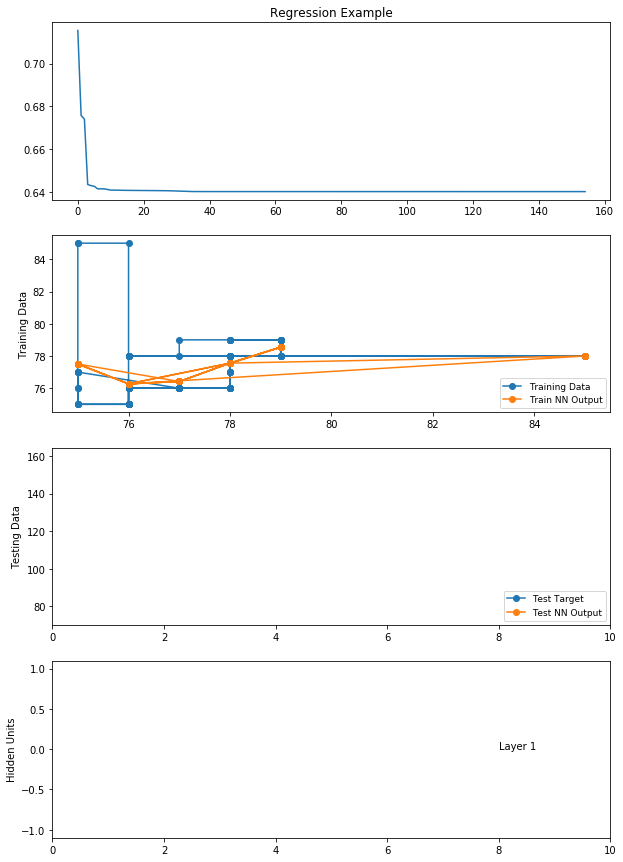

In [417]:
nnet = run(X, T, [50], nIterations=1000, verbose=True)
nnet

In [420]:
nnet = run(X, T, [20, 5, 3], nIterations=1000, verbose=True, saveWeightsHistory=True)
nnet

SCG: Iteration 100 fValue Eval 0.409861903369 Scale 1e-15
4.76344050954e-17


NeuralNetwork(1, [20, 5, 3], 1)
   Network was trained for 190 iterations that took 0.2825 seconds. Final error is 0.6402042938619612.

In [421]:
from matplotlib import animation
import matplotlib # for next statement
matplotlib.rc('animation', html='html5')

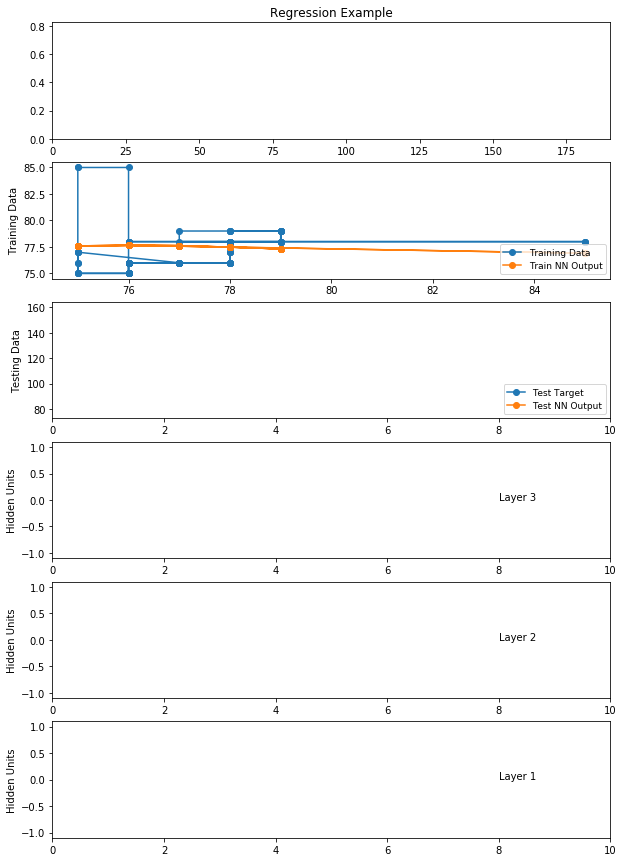

In [422]:
weightsHistory = nnet.getWeightsHistory()
nnet._unpack(weightsHistory[0,:])
Y = nnet.use(X)
Ytest, Ztest = nnet.use(Xtest, allOutputs=True)

nHLayers = len(nnet.nhs)
nPlotRows = 3 + nHLayers

fig = plt.figure(figsize=(10, 15))
plt.subplot(nPlotRows, 1, 1)
errors = nnet.getErrors()
errorsLine = plt.plot(0,errors[0])[0]
plt.xlim(0,len(errors))
plt.ylim(0,np.max(errors)*1.1)

plt.title('Regression Example')

plt.subplot(nPlotRows, 1, 2)
plt.plot(X, T, 'o-', label='Training Data')
trainLine = plt.plot(X, Y, 'o-', label='Train NN Output')[0]
plt.ylabel('Training Data')
plt.legend(loc='lower right', prop={'size':9})

plt.subplot(nPlotRows, 1, 3)
plt.plot(Xtest, Ttest, 'o-', label='Test Target')
testLine = plt.plot(Xtest, Ytest, 'o-', label='Test NN Output')[0]
plt.ylabel('Testing Data')
plt.xlim(0, 10)
plt.legend(loc='lower right', prop={'size':9})
hiddenOutputLines = []
for i in range(nHLayers):
    layer = nHLayers-i-1
    plt.subplot(nPlotRows, 1, i+4)
    hiddenOutputLines.append( plt.plot(Xtest, Ztest[layer]) )
    plt.xlim(0, 10)
    plt.ylim(-1.1, 1.1)
    plt.ylabel('Hidden Units')
    plt.text(8, 0, 'Layer {}'.format(layer+1))
    
updatesPerFrame = 2

def animator(framei):
    step = framei * updatesPerFrame
    nnet._unpack(weightsHistory[step,:])
    Y = nnet.use(X)
    Ytest, Ztest = nnet.use(Xtest, allOutputs=True)
    errorsLine.set_data(range(step),errors[:step])
    trainLine.set_ydata(Y)
    testLine.set_ydata(Ytest)
    
    for iLayer in range(len(hiddenOutputLines)):
        HOLines = hiddenOutputLines[iLayer]
        Zlayer = Ztest[nHLayers - iLayer - 1]
        for iUnit in range(len(HOLines)):
            HOLines[iUnit].set_ydata(Zlayer[:,iUnit])
    return [errorsLine, trainLine, testLine] + hiddenOutputLines

## Methods

Notes: 
* could seperate all items into train and test data
* could train on one item, test on another

In [41]:
# This method acts as the reinforcement and accounts for the 15% handling cost for selling items on the market
def checkForProfit(price_sold, price_bought):
    profit = (price_sold - (price_sold * 0.15)) - price_bought
    if profit > 0:
        return 1
    elif profit < 0:
        return -1
    else:
        return 0

## Results

## Conclusions

## References